# Testing Mouth Open/Close Detection

In [1]:
from commonfunctions import *
import math
from skimage import filters
from skimage import data
from skimage.color import rgb2gray

import dlib

%matplotlib inline
%load_ext autoreload
%autoreload 2

(768, 512, 3)


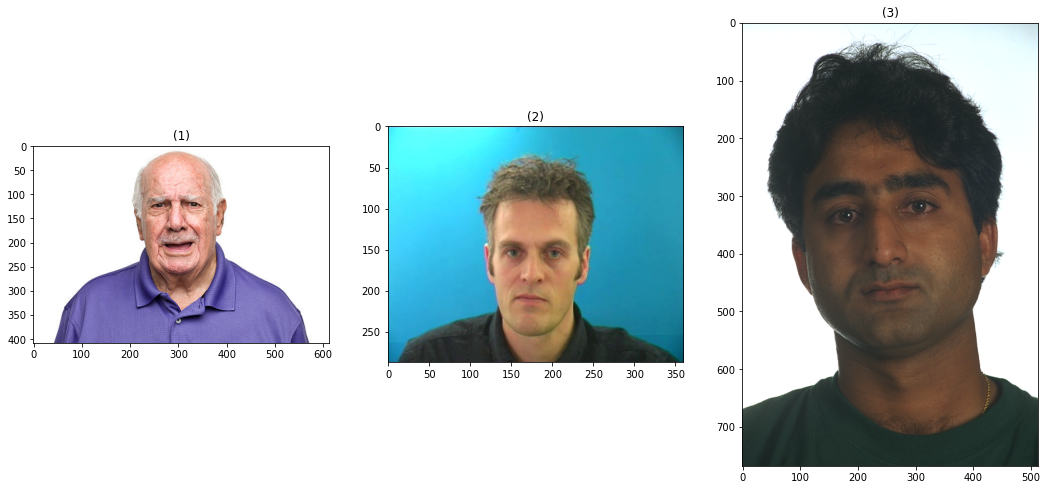

In [11]:
img_PPM=io.imread("00616_940928_fb.ppm")
print(img_PPM.shape)
img_open = io.imread('test3.jpg')
# img_open=img_open[:,:,:3]
img_close = io.imread('frame69.jpg')
show_images([img_open, img_close,img_PPM])

In [12]:
def detectMouth(img):
    # detect face:
    detector = dlib.get_frontal_face_detector()
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))

    face = img[d.top():d.bottom(), d.left():d.right()]
    dimensions_face=face.shape
    mouth = face[int(dimensions_face[0]/2+(0.05*(d.bottom()-d.top()))):,:,:]


    quarter_face=mouth.shape[1]//4
    mouth= mouth[:,quarter_face:quarter_face*3,:]

    dimensions_mouth=mouth.shape

    io.imshow(face)
    io.imshow(mouth)
    io.show()
    return mouth , dimensions_mouth

In [13]:
def PixelsCount(image):
    return image.shape[0]*image.shape[1]

In [14]:
def selectLipRegion(mouth, dimensions_mouth):
    R = mouth[:,:,0]
    G = mouth[:,:,1]

    print(mouth.shape)
    # calculate chromatism
    chromatism = 2 * np.arctan((R-G)/R) / np.pi

    io.imshow(chromatism)
    io.show()
    chromatism = chromatism.reshape(-1,1)

    sorted_chromatism = -np.sort(-chromatism,axis=None,)

    chromatism_mouth_perc = int(chromatism.shape[0] * 0.15)
    print("15 percent :",chromatism_mouth_perc)
    chromatsim_largest_twenty=sorted_chromatism[0:chromatism_mouth_perc]


    chromatism = chromatism.reshape(dimensions_mouth[0],dimensions_mouth[1])
    io.imshow(chromatism)
    io.show()

    #print(chromatism in chromatsim_largest_twenty)
    new_img = np.zeros(dimensions_mouth)

    for i in range(0,dimensions_mouth[0]):
        for j in range(0,dimensions_mouth[1]):
            if chromatism[i,j] in chromatsim_largest_twenty:
                new_img[i,j]=255
            else:
                new_img[i,j]=0

    #new_img = chromatism[x for x in chromatsim_largest_twenty]
    io.imshow(new_img)
    io.show()

    return new_img


In [15]:
def contourIntersect(contour1, contour2):
    intersection = cv2.pointPolygonTest(contour1,(int(contour2[0][0][0]),int(contour2[0][0][1])),False)
    return intersection

In [16]:
def getROI(mouth):

    #showing contours
    temp = np.zeros_like(mouth)
    #one connected component or 2 connected component
    connected = True  

    # get 2 largest contours 
    largest_two_cnts=contours[0:2]  
    print(cv2.contourArea(largest_two_cnts[0]))
    cv2.drawContours(temp, largest_two_cnts, -1, (255,0,0), 1) #draw all contours
    show_images([temp],["2 largest cnts"])


    #if 2 components are nested , inside = 1 , else , components are not connected
    inside = contourIntersect(largest_two_cnts[0],largest_two_cnts[1])   

    if inside>0:
        connected=True
    else:
        connected=False

    if connected: # if connected , draw bounding rect for largest (outer contour)
        x,y,w,h = cv2.boundingRect(largest_two_cnts[0])
        cv2.rectangle(temp,(x,y),(x+w,y+h),(255,255,255),1)
        print("connected ",x,y,w,h)
        ROI = mouth_open[max(2,y-int(0.10*mouth.shape[0])):min(int(y+h+int(0.10*mouth.shape[0])),mouth.shape[0]),max(2,x-int(0.2*mouth.shape[1])):min(mouth.shape[1],x+w+int(0.2*mouth.shape[1])),:]
    else:   #else , draw bounding rect for both region
        x1,y1,w1,h1 = cv2.boundingRect(largest_two_cnts[0])     
        cv2.rectangle(temp,(x1,y1),(x1+w1,y1+h1),(255,255,255),1)

        x2,y2,w2,h2 = cv2.boundingRect(largest_two_cnts[1])
        cv2.rectangle(temp,(x2,y2),(x2+w2,y2+h2),(255,255,255),1)

        print("area difference : ",cv2.contourArea(largest_two_cnts[0])-cv2.contourArea(largest_two_cnts[1]))           
        if cv2.contourArea(largest_two_cnts[0])-cv2.contourArea(largest_two_cnts[1]) >500:      #if the size of second largest is negligible in comparison to first , discard it
            print("not connected ",x1,y1,w1,h1)
            ROI = mouth_open[max(2,y1-int(0.10*mouth.shape[0])):min(mouth.shape[0],y1+h1+int(0.10*mouth.shape[0])),max(2,x1-int(0.2*mouth.shape[1])):min(mouth.shape[1],x1+w1+int(0.2*mouth.shape[1])),:]
        else:
            minx=min([x1,x2])               #get the minx maxx miny maxy of the 2 bounding rectangles combined
            maxx=max([x1+w1,x2+w2])
            miny=min([y1,y2])
            maxy=max([y1+h1,y2+h2])
            print("not connected ",miny,maxy,minx,maxx)
            ROI = mouth_open[max(2,miny-int(0.10*mouth.shape[0])):min(mouth.shape[0],maxy+int(0.10*mouth.shape[0])),max(2,minx-int(0.2*mouth.shape[1])):min(mouth.shape[1],maxx+int(0.2*mouth.shape[1])),:]         #retrieve ROI

    return ROI

Number of faces detected: 1
Detection 0: Left: 218 Top: 81 Right: 373 Bottom: 236


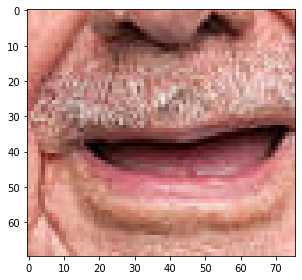

(70, 76, 3)


C:\Users\myass\anaconda3\envs\gp\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


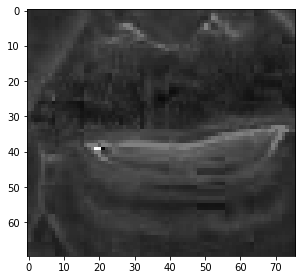

15 percent : 798


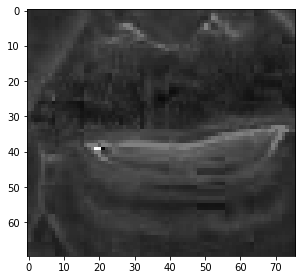

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


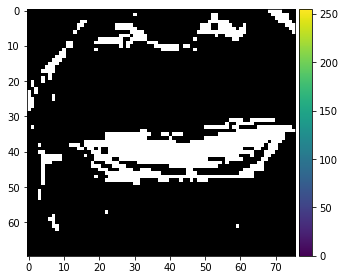

<class 'numpy.uint8'>


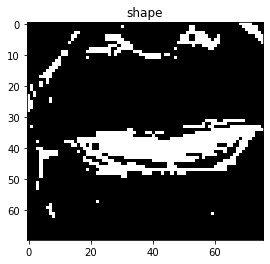

In [17]:
mouth_open , dim_open = detectMouth(img_open)
mouth = selectLipRegion(mouth_open, dim_open)
mouth = np.uint8( rgb2gray(mouth) *255 ) 

print(type(mouth[0][0]))

show_images([mouth],["shape"])



contours, hierarchy = cv2.findContours(mouth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



In [18]:
contours=sorted(contours,key=lambda x: cv2.contourArea(x),reverse=True) #sorted contours descendingly according to area

595.5


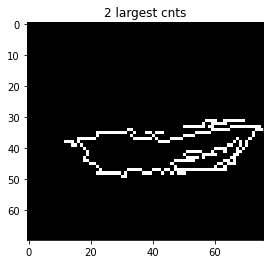

connected  12 31 64 19


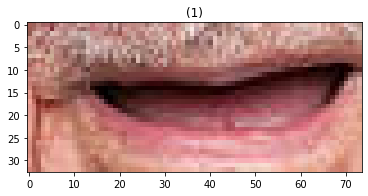

In [19]:
# cv2.drawContours(temp, contours, 0, (255,0,0), 1) #draw all contours
# show_images([temp])

ROI = getROI(mouth)

show_images([ROI])


### Challenges:
1. how to detect whether lips is connected or not -> when to select one biggest contour / 2 biggest contours?

# Find mouth contours


(33, 74, 3)
number pixels : 2442
skin value : 1562
n : 162
iteration : 1
Threshold [35]
165
158
182
162
170
145
168
213
192
179
175
218
202
199
185
207
199
206
160
218
161
187
196
191
193
194
162
190
216
186
214
201
186
197
204
219
238
212
232
182
153
130
162
188
165
194
216
197
222
229
255
239
193
188
212
216
220
242
196
223
226
227
229
228
243
206
224
191
208
217
237
214
198
184
156
164
192
194
207
125
200
191
183
194
202
165
147
174
195
198
200
189
158
200
148
214
205
186
194
209
197
225
201
223
203
188
197
211
193
220
251
193
215
138
160
165
174
198
168
193
158
186
208
208
235
202
206
210
208
208
213
215
220
204
204
213
206
213
228
206
240
198
206
184
178
235
223
200
144
204
222
188
155
220
218
193
167
204
210
186
200
190
196
197
194
162
181
174
148
199
191
203
179
175
224
192
187
206
194
216
169
220
237
177
246
191
155
195
204
201
138
212
178
186
217
168
195
184
195
220
191
232
185
205
239
240
212
206
208
194
202
223
231
219
212
216
201
178
187
166
188
207
199
199
166
163
199
186


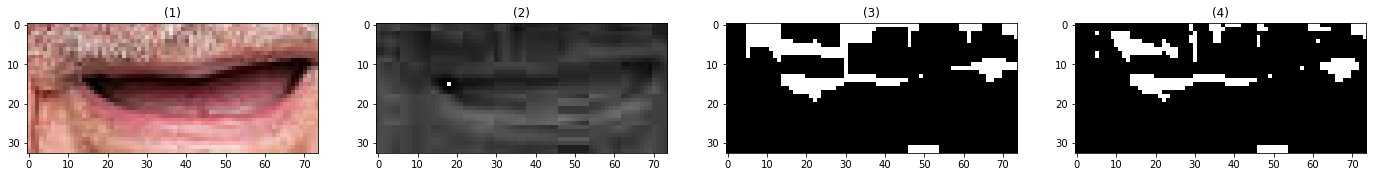

In [20]:
#calculate threshold T for segmentation

print(ROI.shape)

#calculate R - G 
red_minus_green = ROI[:,:,0]-ROI[:,:,1]

skin_value=0
n=0
new_img=np.zeros((ROI.shape[0],ROI.shape[1]))
k=0 #debug

while skin_value <= int((1/20)*PixelsCount(new_img)):
    #reshape R - G  to a vector
    red_minus_green_vector = red_minus_green.reshape(-1,1)

    top_10 = int(0.1*red_minus_green_vector.shape[0])  # top 10% pixels number in R-G values


    red_minus_green_sorted = sorted(red_minus_green_vector)  # ascendigly sort R_G values
    red_minus_green_top_10_plus_n = red_minus_green_sorted[0:top_10+n]   # pick smallest 10% values + n

    red_minus_green = red_minus_green.reshape(ROI.shape[0],ROI.shape[1])    #rstore the vector into an image again 

    new_img = red_minus_green == red_minus_green_top_10_plus_n[0]  # set pixels having value equal to top value to 1  

    for i in range(1,top_10+n):       #repeat for the top 10% values in R-G
        new_img |= red_minus_green == red_minus_green_top_10_plus_n[i] 

    new_img = np.uint8(new_img*255)  #convert float to uint
    new_img = closing(new_img,selem=square(5))  #perform a closing operation to remove gaps

    contours, hierarchy = cv2.findContours(new_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours=sorted(contours,key=lambda x: cv2.contourArea(x),reverse=True) #sorted contours descendingly according to area

    largest_two_cnts=contours[0:2]
    x1,y1,w1,h1 = cv2.boundingRect(largest_two_cnts[0])     

    #cv2.rectangle(new_img,(x1,y1),(x1+w1,y1+h1),(255,255,255),1)

    minx=min([x1])               #get the minx maxx miny maxy of the 2 bounding rectangles combined
    maxx=max([x1+w1])
    miny=min([y1])
    maxy=max([y1+h1])

    mouth_region = new_img[miny:maxy,minx:maxx]

    skin_value = PixelsCount(new_img)-PixelsCount(mouth_region)

    n += int( (1/15)*PixelsCount(new_img) )
    k+=1

    print("number pixels :",PixelsCount(new_img))
    print("skin value :" ,skin_value)
    print("n :" , n)
    print("iteration :" , k)

T = red_minus_green_top_10_plus_n[-1]

print("Threshold",T) 

final_image = np.zeros((red_minus_green.shape[0],red_minus_green.shape[1]))

for i in range(red_minus_green.shape[0]):
    for j in range(red_minus_green.shape[1]):
        print(ROI[:,:,0][i,j])

        if (1)*ROI[:,:,0][i,j] - ROI[:,:,1][i,j] <= T:
            final_image[i,j] = 1 
        elif((0)*ROI[:,:,0][i,j] - ROI[:,:,1][i,j] > T):
            final_image[i,j] = 0 

# final_image[red_minus_green <= T] = (255)*ROI[:,:,0] * ROI[:,:,1] 
# final_image[red_minus_green > T] = (0)*ROI[:,:,0] * ROI[:,:,1]

show_images([ROI,red_minus_green,new_img,final_image])
